Epoch: 0.0, Train acc: 0.06855, Test acc: 0.0722
Epoch: 1.0, Train acc: 0.9409, Test acc: 0.9378
Epoch: 2.0, Train acc: 0.9487166666666667, Test acc: 0.9457
Epoch: 3.0, Train acc: 0.9565666666666667, Test acc: 0.9475
Epoch: 4.0, Train acc: 0.9586833333333333, Test acc: 0.9523
Epoch: 5.0, Train acc: 0.9601666666666666, Test acc: 0.9519
Epoch: 6.0, Train acc: 0.9649666666666666, Test acc: 0.953
Epoch: 7.0, Train acc: 0.9641333333333333, Test acc: 0.9533
Epoch: 8.0, Train acc: 0.9665, Test acc: 0.952
Epoch: 9.0, Train acc: 0.9684833333333334, Test acc: 0.9582
Epoch: 10.0, Train acc: 0.9674333333333334, Test acc: 0.9554
Epoch: 11.0, Train acc: 0.9689666666666666, Test acc: 0.9554
Epoch: 12.0, Train acc: 0.9712, Test acc: 0.9585
Epoch: 13.0, Train acc: 0.9690333333333333, Test acc: 0.9539
Epoch: 14.0, Train acc: 0.9717666666666667, Test acc: 0.957
Epoch: 15.0, Train acc: 0.9702333333333333, Test acc: 0.9562
Epoch: 16.0, Train acc: 0.97215, Test acc: 0.9581
Epoch: 17.0, Train acc: 0.9735, Te

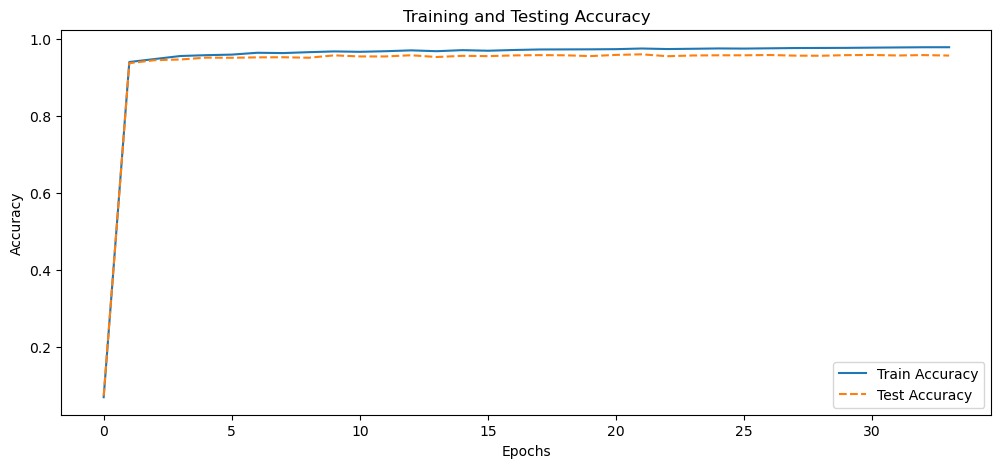

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.optimizer import SGD, RMSprop
from common.layers import Affine, Relu, SoftmaxWithLoss, BatchNormalization
from collections import OrderedDict

class MultiLayerNet:
    def __init__(self, input_size, hidden_sizes, output_size, weight_init_std='He', use_batchnorm=False):
        self.params = {}
        self.layers = OrderedDict()
        
        self.layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        for i in range(1, len(self.layer_sizes)):
            weight_std = np.sqrt(2. / self.layer_sizes[i-1]) if weight_init_std == 'He' else np.sqrt(1. / self.layer_sizes[i-1])
            self.params['W' + str(i)] = weight_std * np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i])
            self.params['b' + str(i)] = np.zeros(self.layer_sizes[i])
            self.layers['Affine' + str(i)] = Affine(self.params['W' + str(i)], self.params['b' + str(i)])
            
            if use_batchnorm and i < len(self.layer_sizes) - 1:
                self.layers['BatchNorm' + str(i)] = BatchNormalization(np.ones(self.layer_sizes[i]), np.zeros(self.layer_sizes[i]))
                
            if i < len(self.layer_sizes) - 1:
                self.layers['Relu' + str(i)] = Relu()
        
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
        
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        return np.sum(y == t) / float(x.shape[0])
        
    def gradient(self, x, t):
        self.loss(x, t)
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        for i in range(1, len(self.layer_sizes)):
            grads['W' + str(i)] = self.layers['Affine' + str(i)].dW
            grads['b' + str(i)] = self.layers['Affine' + str(i)].db
            
            if 'BatchNorm' + str(i) in self.layers:
                grads['gamma' + str(i)] = self.layers['BatchNorm' + str(i)].dgamma
                grads['beta' + str(i)] = self.layers['BatchNorm' + str(i)].dbeta
        
        return grads

class MultiLayerNetTrainer:
    def __init__(self, input_size, hidden_sizes, output_size, iters_num=10000, batch_size=100, learning_rate=0.01, use_batchnorm=False):
        self.network = MultiLayerNet(input_size, hidden_sizes, output_size, use_batchnorm=use_batchnorm)
        self.iters_num = iters_num
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []
        self.optimizer = RMSprop()

    def train(self, x_train, t_train, x_test, t_test):
        train_size = x_train.shape[0]
        iter_per_epoch = max(train_size / self.batch_size, 1)

        for i in range(self.iters_num):
            batch_mask = np.random.choice(train_size, self.batch_size)
            x_batch = x_train[batch_mask]
            t_batch = t_train[batch_mask]

            grad = self.network.gradient(x_batch, t_batch)
            self.optimizer.update(self.network.params, grad)

            loss = self.network.loss(x_batch, t_batch)
            self.train_loss_list.append(loss)

            if i % iter_per_epoch == 0:
                train_acc = self.network.accuracy(x_train, t_train)
                test_acc = self.network.accuracy(x_test, t_test)
                self.train_acc_list.append(train_acc)
                self.test_acc_list.append(test_acc)
                print(f"Epoch: {i // iter_per_epoch}, Train acc: {train_acc}, Test acc: {test_acc}")

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

iters_num = 10000
batch_size = 200
learning_rate = 0.01
hidden_sizes = [15, 15, 15, 15, 15]  # 5 hidden layers with 15 units each

trainer = MultiLayerNetTrainer(input_size=784, hidden_sizes=hidden_sizes, output_size=10, iters_num=iters_num, batch_size=batch_size, learning_rate=learning_rate, use_batchnorm=True)
trainer.train(x_train, t_train, x_test, t_test)

plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(trainer.train_acc_list)), trainer.train_acc_list, label='Train Accuracy')
plt.plot(np.arange(len(trainer.test_acc_list)), trainer.test_acc_list, label='Test Accuracy', linestyle='--')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
